In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import io
import rasterio
import numpy as np
from pykrige.ok import OrdinaryKriging
from rasterio.transform import Affine
from shapely.geometry import box
from rasterio.mask import mask
from matplotlib.colors import ListedColormap
from PIL import Image


# Working with Tif files

### Opening tif files

In [21]:
raster = rasterio.open('data/original.tif')
bands = {'red':1, 'blue':2, 'green':3, 'nir':8}
# bands = {band: num for band, num in enumerate(raster.descriptions, start = 1)}
red = raster.read(bands.get('red'))
green = raster.read(bands.get('green'))
blue = raster.read(bands.get('blue'))

### Plot the bands and true color

In [22]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [23]:
b = raster.bounds
bounds_extent = np.asarray([b.left, b.right, b.bottom, b.top])



band_mask = np.isnan(red)
red[band_mask] = 0

green[band_mask] = 0

blue[band_mask] = 0
# Function to normalize the grid values
# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())



Normalized bands
0.0 - 1.0 mean: 0.05233614067434896
0.0 - 1.0 mean: 0.12601102661201902
0.0 - 1.0 mean: 0.09269380353662701


In [24]:
def plot_raster_band(band: np.array, cmap: str):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.axis('off')
    ax.imshow(band, extent=bounds_extent, cmap=cmap)
    ax.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    plt.tight_layout()
    plt.show()

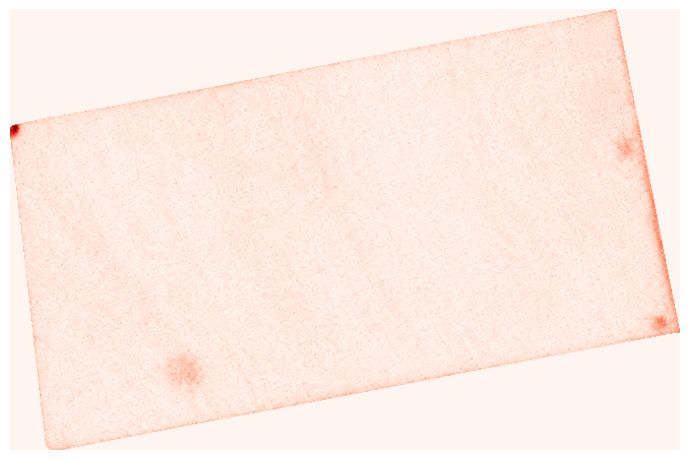

In [25]:
redn[band_mask] = np.nan
plot_raster_band(redn, cmap='Reds')


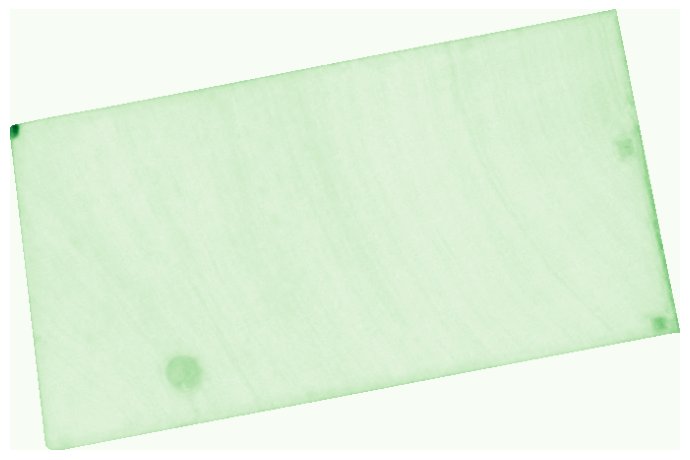

In [26]:
greenn[band_mask] = np.nan
plot_raster_band(greenn, cmap='Greens')


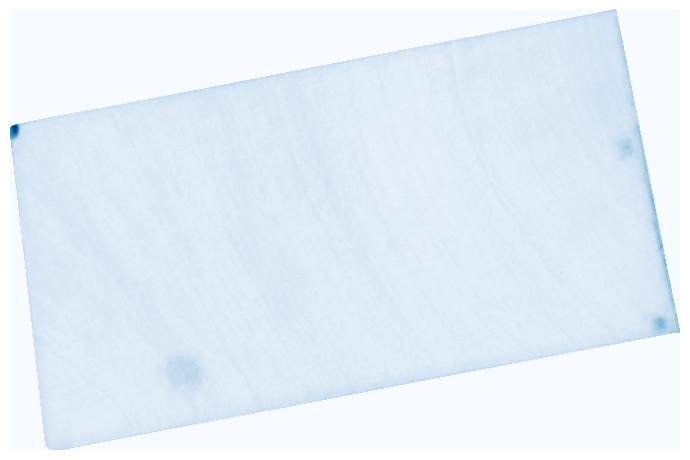

In [27]:
bluen[band_mask] = np.nan
plot_raster_band(bluen, cmap='Blues')

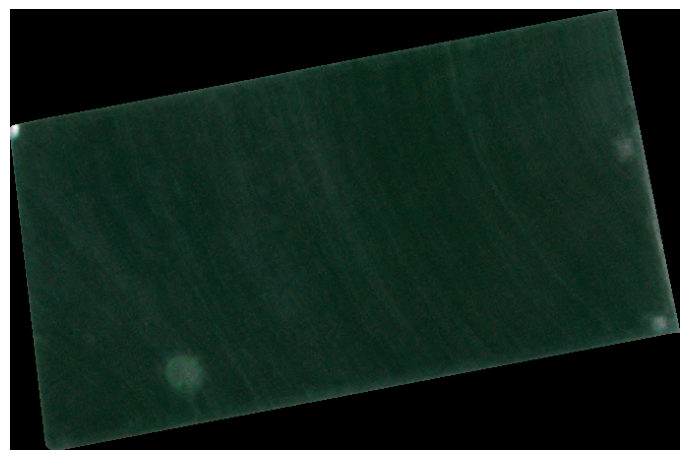

In [28]:
# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))
plot_raster_band(rgb, cmap=None)

### How to remove the black background from the RGB image.

In [29]:
def remove_blue_background(buf: io.BytesIO, local_rgb_path: str) -> None:
    buf.seek(0)
    img = Image.open(buf)
    rgba = img.convert("RGBA")
    datas = rgba.getdata()

    newData = []

    for item in datas:
        if item[0] == 0 and item[1] == 0 and item[2] == 255:  # finding yellow colour
            # replacing it with a transparent value
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    rgba.putdata(newData)
    rgba.save(local_rgb_path, format='PNG')
    display(rgba)

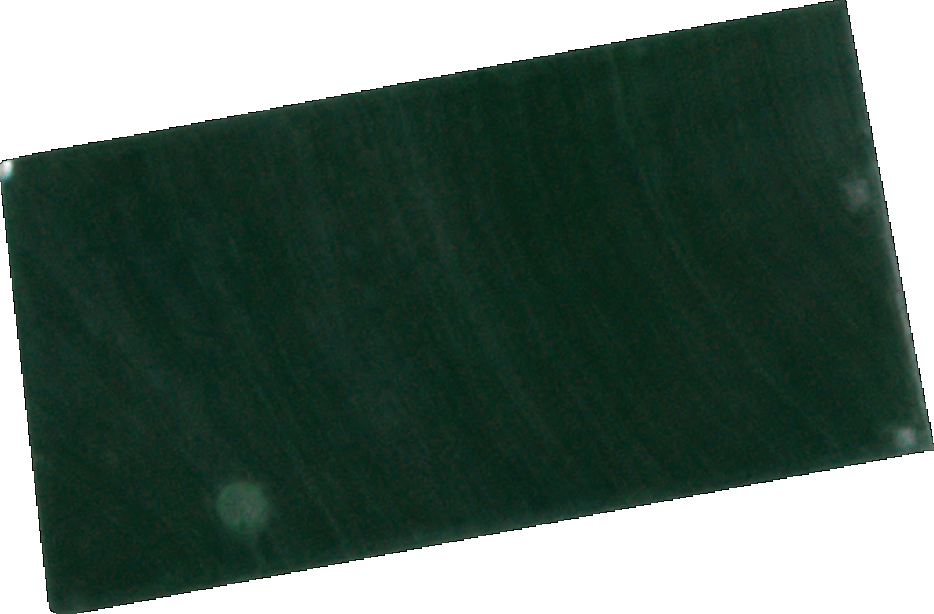

In [30]:
cmap = ListedColormap(['#0000FF'])
px = 1024
fig, ax = plt.subplots(
    figsize=(px / 300, px / 300), dpi=300)
ax.axis('off')
masked = np.ma.masked_where(np.nan_to_num(
    red, nan=0) != 0, np.nan_to_num(red, nan=0))
ax.imshow(rgb, extent=bounds_extent)
ax.imshow(masked, alpha=1, cmap=cmap, extent=bounds_extent)
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, transparent=True,
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)
plt.close()
remove_blue_background(buf = buf, local_rgb_path='data/outputs/rgb.png')

### Vegetation index

In [31]:
raster_path = 'data/original.tif'

raster = rasterio.open(raster_path)
bands = {'red':6, 'blue':2, 'green':4, 'nir':8, 'costal_blue':1, 'green_I':3,'yellow':5, 'red_edge':7}

In [32]:
raster_path = 'data/original.tif'

raster = rasterio.open(raster_path)
b = raster.bounds
bounds_extent = np.asarray([b.left, b.right, b.bottom, b.top])
bands = {'red':6, 'blue':2, 'green':4, 'nir':8, 'costal_blue':1, 'green_I':3,'yellow':5, 'red_edge':7}

# Convert to floats
red = raster.read(bands.get('red')).astype('f4')
nir = raster.read(bands.get('nir')).astype('f4')
red_edge =raster.read(bands.get('red_edge')).astype('f4')

np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI using numpy arrays
ndvi = (nir - red) / (nir + red)
ndre = (nir - red_edge)/(nir+red_edge)

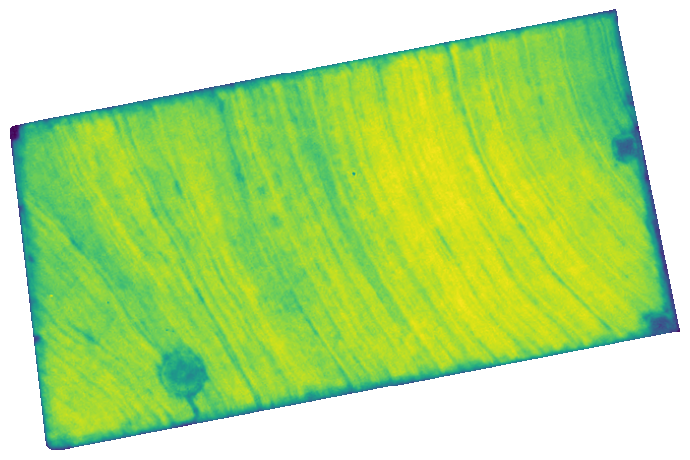

In [33]:
plot_raster_band(band=ndvi, cmap=None)

# Working with shape files

### Opening the file

In [34]:
gdf_base = gpd.read_file('data/basemap_shapefie/basemap.shp')
gdf_precipitation = gpd.read_file('data/precipitation_shapefile/precipitation.shp')

### Checking the projections

When you work with geospatial data pay attention to its attributes, especially projection. If you want to combine information, make sure that they are in the same projection. 

In [35]:
gdf_precipitation.crs

<Derived Projected CRS: EPSG:31981>
Name: SIRGAS 2000 / UTM zone 21S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 60°W and 54°W, northern and southern hemispheres. In remainder of South America - between 60°W and 54°W, southern hemisphere, onshore and offshore.
- bounds: (-60.0, -44.82, -54.0, 4.51)
Coordinate Operation:
- name: UTM zone 21S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [36]:
gdf_base.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [37]:
gdf_base.to_crs(gdf_precipitation.crs, inplace=True)

### plot the map

In [38]:
def plot_map_fazenda(df_base: gpd.GeoDataFrame, df_aditional_info: gpd.GeoDataFrame, title: str):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    base_map = df_base.plot(color='blue', edgecolor='black', ax = ax)
    precipitation = df_aditional_info.plot(ax=base_map, color='red', alpha= 1)
    fig.suptitle(title, fontsize=15, fontweight="bold")
    plt.xlabel(' ', fontsize=12)
    plt.ylabel(' ', fontsize=12)

    # # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)

    # # Add x, y gridlines
    ax.grid(color ='darkgrey',
            linestyle ='-.', linewidth = 0.7,
            alpha = 0.2
            )

    # # Show top values
    ax.invert_yaxis()
    
    plt.show()

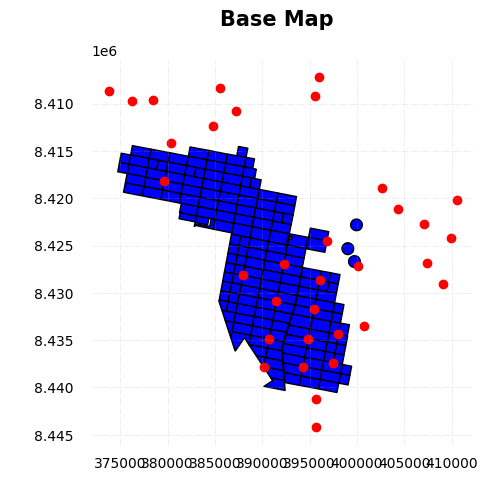

In [39]:

plot_map_fazenda(df_base=gdf_base, df_aditional_info=gdf_precipitation, title="Base Map")


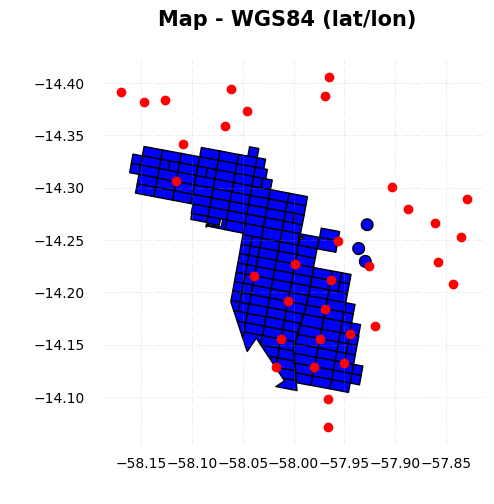

In [40]:
gdf_precipitation.to_crs('EPSG:4326', inplace=True)
gdf_base.to_crs('EPSG:4326', inplace=True)
plot_map_fazenda(df_base=gdf_base, df_aditional_info=gdf_precipitation, title='Map - WGS84 (lat/lon)')

### Spatial Interpolation

In [41]:
gdf_base.head()

,Talhao,geometry
0,0,"POLYGON ((-57.97856 -14.23261, -57.99662 -14.2..."
1,1,"POLYGON ((-57.99860 -14.22694, -58.00029 -14.2..."
2,2,"POLYGON ((-57.98200 -14.21463, -58.00028 -14.2..."
3,3,"POLYGON ((-57.98553 -14.19683, -58.00372 -14.2..."
4,4,"POLYGON ((-57.99582 -14.16163, -57.99304 -14.1..."


In [42]:
gdf_precipitation.head()

,precipitat,geometry
0,2162.0,POINT (-57.96488 -14.40550)
1,1710.0,POINT (-57.96887 -14.38773)
2,1598.0,POINT (-58.06799 -14.35847)
3,2179.0,POINT (-58.04627 -14.37316)
4,2096.0,POINT (-58.06140 -14.39435)


Note that our objective is to interpolate the points of `gdf_precipitation` and create a matrix of order $ n x n $ where the coordinates $ x_i $ and $ y_j $ should be such that $ x_ {min} <x_i <x_ {max} $ and $ y_ { min} <y_i <y_ {max} $  where $ x_ {min} $ is the lowest coordinate value of x at `gdf_base`, $ x_ {max} $ the highest value of x in ` gdf_base `, $ y_ {min} $ is the lowest y coordinate value and $ y_ {max} $ the highest value of y in ` gdf_base `. After creating the matrix, we will save it as a raster file, and use the `rasterio` to filter all the pieces of information out of our base map shapefile. 

  

We will follow the next steps: 

  

1. Define $ x_ {min}, x_ {max}, y_ {min}, y_ {max} $. 

2. Create an array `1d` that have n equally spaced points between $ x_ {min} $ and $ x_ {max} $ 

3. Create an array `1d` that have n equally spaced points between $ y_ {min} $ and $ y_ {max} $ 

4. Interpolation. For this task, we will use as input argument, the X and Y coordinates of `gdf_precipitation` and the accumulated sum of rain mm values. The interpolation will be made considering a grid built from the vectors created in steps 2 and 3. The output will be a $ z_ {nxn}$ array. 

5. Save the interpolated array (Z) into a raster file. 

6. Read the raster file created in step 5 using `rasterio`. 

7. Use the `rasterio`'s `mask` function to mask the interpolated values outside the base map region. We have to use an array that has the `geometry` column of` gdf_base`. 

Steps 1, 2 and 3

In [43]:
# 1: define xmax, ymax, xmin and y min
min_x, min_y, max_x, max_y = gdf_base.total_bounds
# 2 and 3: Horizontal and vertical cell counts should be the same
n_points = 1000
xx_grid_coord = np.linspace(min_x, max_x, n_points)
yy_grid_coord = np.linspace(min_y, max_y, n_points)

Step 4: Interpolation

In [44]:
# 4: Interpolation
x_rain = gdf_precipitation["geometry"].x
y_rain = gdf_precipitation["geometry"].y
values_rain = list(gdf_precipitation.precipitat)
# Generate ordinary kriging object
OK = OrdinaryKriging(
    np.array(x_rain),
    np.array(y_rain),
    values_rain,
    variogram_model = "linear",
    verbose = False,
    enable_plotting = False,
    coordinates_type = "euclidean",
)

# execute the interpolation process using the method execute of our object.
interpolated_values, sigma_squared_p_krig = OK.execute("grid", xx_grid_coord, yy_grid_coord)

Step 5. Save interpolated array (Z) as a raster file.

In [45]:
# method to save an array as a raster file
def export_kde_raster(interpoolated_values: np.array, x_coord: np.array, y_coord: np.array, min_x, max_x, min_y, max_y, proj, filename: str):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(x_coord)
    yres = (max_y - min_y) / len(y_coord)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = interpoolated_values.shape[0],
            width = interpoolated_values.shape[1],
            count = 1,
            dtype = interpoolated_values.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(interpoolated_values, 1)

In [46]:
# Export raster
file_path = "data/outputs/precipitation_interpolated..tif"
export_kde_raster(interpoolated_values=interpolated_values, x_coord=xx_grid_coord, y_coord=yy_grid_coord,
min_x = min_x, max_x = max_x, min_y = min_y, max_y = max_y,
                  proj = gdf_precipitation.crs, 
                  filename = file_path)

Step 6. Read the file created using rasterio.

In [47]:
# Open raster
raster_interpolated = rasterio.open(file_path)

In [48]:
# Create copy of test dataset
gdf_precipitation_copy = gdf_precipitation.copy()


Step 7: Masking the raster using `rasterio.mask.mask`

In [49]:
# Mask raster to counties shape
band_interpolated_masked, affine_transform_masked_raster_interpolated = mask(raster_interpolated, gdf_base.geometry.values, crop = True)

In [50]:
band_interpolated_masked

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [51]:
affine_transform_masked_raster_interpolated

Affine(0.0002397466625282405, 0.0, -58.16157490085823,
       0.0, 0.00023496674749191548, -14.339390829126286)

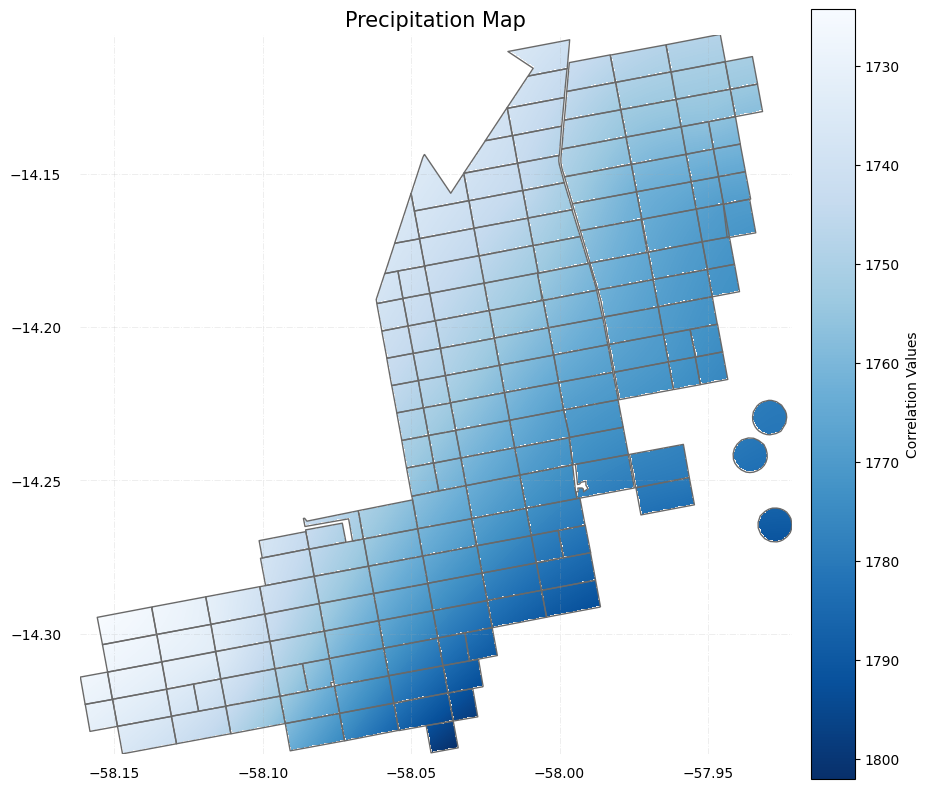

In [54]:
b = raster_interpolated.bounds
bounds_extent = np.asarray([b.left, b.right, b.bottom, b.top])
array_values = band_interpolated_masked.reshape(1000, 1000)
array_values = array_values.astype('float')
array_values[array_values == 0] = np.nan
# Plot data
fig, (ax, cbar_ax) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0.05, 'width_ratios':(0.8,0.05)} )
cbar_kws={"label":"Correlation Values","orientation":"vertical",
#  "ticks":[-1, -0.5,0, 0.5, 1], 
 "extendfrac":100, "drawedges":True }

precipitation_map = ax.imshow(array_values, cmap = "Blues", extent=bounds_extent)
# ax.plot(x_rain, y_rain, 'k.', markersize = 2, alpha = 0.5)
gdf_base.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
# plt.gca().invert_yaxis()
plt.colorbar(precipitation_map, cax=cbar_ax, **cbar_kws)

# # Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# # Add x, y gridlines
ax.grid(color ='darkgrey',
        linestyle ='-.', linewidth = 0.7,
        alpha = 0.2)

# # Show top values
ax.invert_yaxis()

# Set title
ax.set_title('Precipitation Map', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()

https://pygis.io/docs/a_intro.html

https://automating-gis-processes.github.io/CSC/notebooks/L5/raster-map-algebra.html